<a href="https://colab.research.google.com/github/ravirajdasari/deeplearning/blob/master/CatVsDogClassifier_TransferLearning_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [3]:
import json
!mkdir .kaggle

#Enter your kaggle username and api token
token = {"username":<user>,"key":<apikey>}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}


In [4]:
!kaggle datasets list -s 'cats'

ref                                                        title                                                size  lastUpdated          downloadCount  
---------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
chetankv/dogs-cats-images                                  Dogs & Cats Images                                  435MB  2018-04-19 18:20:08          12442  
mmoreaux/audio-cats-and-dogs                               Audio Cats and Dogs                                  97MB  2017-10-05 09:40:26           5040  
biaiscience/dogs-vs-cats                                   Dogs vs Cats                                        817MB  2017-12-05 14:03:33           6081  
tongpython/cat-and-dog                                     Cat and Dog                                         218MB  2018-04-26 10:56:50          22842  
crawford/cat-dataset                                       Cat Dataset

In [5]:
!kaggle datasets download -d chetankv/dogs-cats-images -p /content --force

 96% 417M/435M [00:16<00:00, 18.7MB/s]
100% 435M/435M [00:17<00:00, 26.8MB/s]


In [6]:
!unzip dogs-cats-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3711.jpg  
  inflating: dog vs cat/dataset/training_

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
%load_ext tensorboard

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime

print(tf.__version__)

2.3.0


In [16]:
pre_trained_model = ResNet50(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = True

pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
last_output = pre_trained_model.layers[-1].output

In [18]:
last_output

<tf.Tensor 'conv5_block3_out/Relu_1:0' shape=(None, 7, 7, 2048) dtype=float32>

In [20]:
x = Flatten()(last_output)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)                  
x = Dense(1, activation='sigmoid')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=2e-5), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory("dataset/training_set/",
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory("dataset/test_set/",
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))      

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None
)

In [22]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 10,
            validation_steps = 50,
            verbose = 2)

Epoch 1/10
100/100 - 88s - loss: 0.3659 - accuracy: 0.8944 - val_loss: 1.8100 - val_accuracy: 0.5025
Epoch 2/10
100/100 - 87s - loss: 0.1701 - accuracy: 0.9447 - val_loss: 3.1011 - val_accuracy: 0.4988
Epoch 3/10
100/100 - 87s - loss: 0.1201 - accuracy: 0.9622 - val_loss: 1.7235 - val_accuracy: 0.4581
Epoch 4/10
100/100 - 87s - loss: 0.0870 - accuracy: 0.9666 - val_loss: 1.1978 - val_accuracy: 0.5106
Epoch 5/10
100/100 - 87s - loss: 0.1306 - accuracy: 0.9544 - val_loss: 1.0887 - val_accuracy: 0.6025
Epoch 6/10
100/100 - 87s - loss: 0.0681 - accuracy: 0.9762 - val_loss: 0.6123 - val_accuracy: 0.7900
Epoch 7/10
100/100 - 87s - loss: 0.0572 - accuracy: 0.9766 - val_loss: 0.3779 - val_accuracy: 0.8881
Epoch 8/10
100/100 - 86s - loss: 0.0595 - accuracy: 0.9766 - val_loss: 0.1575 - val_accuracy: 0.9513
Epoch 9/10
100/100 - 86s - loss: 0.0586 - accuracy: 0.9772 - val_loss: 0.1291 - val_accuracy: 0.9706
Epoch 10/10
100/100 - 87s - loss: 0.0582 - accuracy: 0.9831 - val_loss: 0.0633 - val_accura

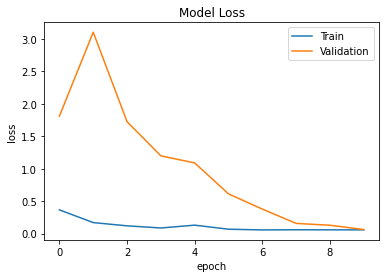

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)

print('\nTest accuracy:', test_acc)

63/63 - 15s - loss: 0.0719 - accuracy: 0.9775

Test accuracy: 0.9775000214576721
